<a href="https://colab.research.google.com/github/Vhernan123/Notebook-Trabajo-Final-Master/blob/main/evaluacion_ambos_modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


In [ ]:
# Lectura de Dataset
ruta = "/content/drive/MyDrive/mis_archivos_tfm/mi_grilla_original.csv"
base_modelo = pd.read_csv(ruta)
base_modelo.drop("Unnamed: 0", axis=1, inplace=True)

# MODELOS DE RANDOM FOREST REGRRESION

regresion

Shape después de filtrar y_reg: (41328, 25)
Resumen de y_reg:
count    41328.000000
mean        24.142131
std         12.358817
min          0.000000
25%         17.000000
50%         25.000000
75%         32.000000
max        325.000000
Name: y_reg, dtype: float64

Fecha de corte (train hasta aquí): 2024-04-30T00:00:00.000000000
Tamaño train: (33075, 20)  | Tamaño test: (8253, 20)

=== Random Forest Regressor ===
Train -> MAE: 3.4218  | RMSE: 5.0716  | R²: 0.7117
Test  -> MAE: 5.894  | RMSE: 6.9237  | R²: 0.1988

=== IMPORTANCIA DE VARIABLES (RF) ===
                 variable  importancia
2      delitos_total_lag1     0.200240
12     delitos_total_lag6     0.130695
4      delitos_total_lag2     0.067418
1              prop_mujer     0.060514
10     delitos_total_lag5     0.058769
14     delitos_total_lag7     0.058202
8      delitos_total_lag4     0.057686
6      delitos_total_lag3     0.052639
0              edad_media     0.045876
11  delitos_con_arma_lag5     0.038667
9   delitos_c

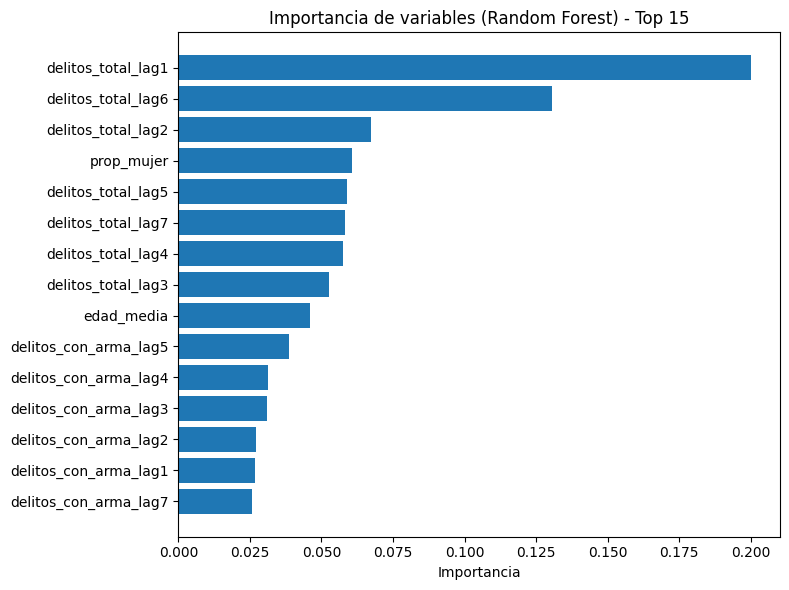

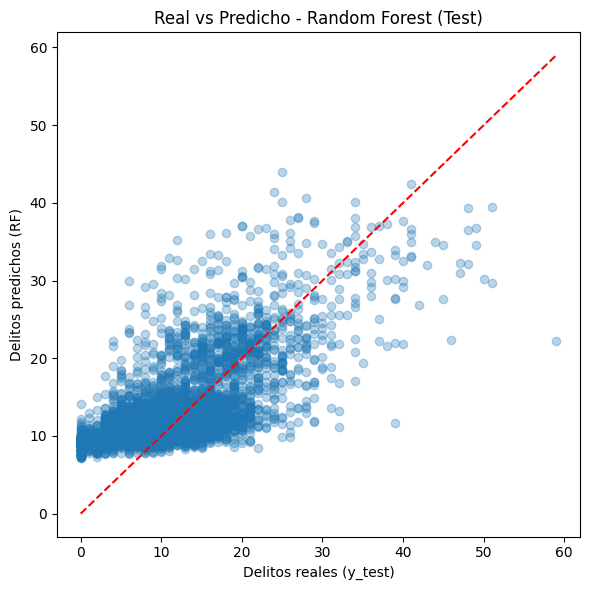

In [ ]:
# ============================================
# 0. IMPORTS
# ============================================
#import numpy as np
#import pandas as pd

from sklearn.impute import SimpleImputer
#from sklearn.preprocessing import StandardScaler
#from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#import matplotlib.pyplot as plt

# ============================================
# 1. PARTIMOS DE LA GRILLA: base_modelo
#    (ya construida previamente e incluye y_reg)
# ============================================

dfm = base_modelo.copy()

# Asegurar tipo datetime en fecha
dfm["fecha"] = pd.to_datetime(dfm["fecha"], errors="coerce")

# Ordenar por sector y fecha
dfm = dfm.sort_values(["sector_id", "fecha"])

# Eliminar filas donde falte la target (por seguridad)
dfm = dfm.dropna(subset=["y_reg"]).copy()

print("Shape después de filtrar y_reg:", dfm.shape)
print("Resumen de y_reg:")
print(dfm["y_reg"].describe())

# ============================================
# 2. DEFINIR VARIABLES PREDICTORAS Y TARGET
# ============================================

features = [
    "edad_media", "prop_mujer",

    "delitos_total_lag1",    "delitos_con_arma_lag1",
    "delitos_total_lag2",    "delitos_con_arma_lag2",
    "delitos_total_lag3",    "delitos_con_arma_lag3",
    "delitos_total_lag4",    "delitos_con_arma_lag4",
    "delitos_total_lag5",    "delitos_con_arma_lag5",
    "delitos_total_lag6",    "delitos_con_arma_lag6",
    "delitos_total_lag7",    "delitos_con_arma_lag7",

    "anio", "mes", "dia_semana", "es_fin_semana"
]

X = dfm[features]
y = dfm["y_reg"]

# ============================================
# 3. SPLIT TEMPORAL: 80% de las fechas para TRAIN, 20% para TEST
# ============================================

fechas_unicas = np.sort(dfm["fecha"].unique())
idx_corte = int(len(fechas_unicas) * 0.8)
fecha_corte = fechas_unicas[idx_corte]

print("\nFecha de corte (train hasta aquí):", fecha_corte)

mask_train = dfm["fecha"] <= fecha_corte
mask_test  = dfm["fecha"] >  fecha_corte

X_train, X_test = X[mask_train], X[mask_test]
y_train, y_test = y[mask_train], y[mask_test]

print("Tamaño train:", X_train.shape, " | Tamaño test:", X_test.shape)

# ============================================
# 4. DEFINIR PIPELINE CON RANDOM FOREST
# ============================================

pipe_rf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("rf", RandomForestRegressor(
            n_estimators=100,
            max_depth=30,
            min_samples_leaf=5,
            random_state=42,
            n_jobs=-1
        ))
])

# ============================================
# 5. ENTRENAR MODELO
# ============================================

pipe_rf.fit(X_train, y_train)

# ============================================
# 6. PREDICCIONES Y EVALUACIÓN
# ============================================

def evaluar_modelo_reg(nombre, modelo, X_train, y_train, X_test, y_test):
    """Calcula MAE, RMSE y R2 en train y test y los imprime."""
    y_pred_train = modelo.predict(X_train)
    y_pred_test  = modelo.predict(X_test)

    mae_train  = mean_absolute_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    r2_train   = r2_score(y_train, y_pred_train)

    mae_test  = mean_absolute_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2_test   = r2_score(y_test, y_pred_test)

    print(f"\n=== {nombre} ===")
    print("Train -> MAE:", round(mae_train,4),
          " | RMSE:", round(rmse_train,4),
          " | R²:", round(r2_train,4))
    print("Test  -> MAE:", round(mae_test,4),
          " | RMSE:", round(rmse_test,4),
          " | R²:", round(r2_test,4))

    return {
        "mae_train": mae_train, "rmse_train": rmse_train, "r2_train": r2_train,
        "mae_test": mae_test,   "rmse_test": rmse_test,   "r2_test": r2_test
    }

result_rf = evaluar_modelo_reg(
    "Random Forest Regressor",
    pipe_rf,
    X_train, y_train,
    X_test, y_test
)

# ============================================
# 7. IMPORTANCIA DE VARIABLES (RF)
# ============================================

rf_model = pipe_rf.named_steps["rf"]

importancias = rf_model.feature_importances_
importancias_df = (
    pd.DataFrame({
        "variable": features,
        "importancia": importancias
    })
    .sort_values("importancia", ascending=False)
)

print("\n=== IMPORTANCIA DE VARIABLES (RF) ===")
print(importancias_df)

# Gráfico de barras de importancia (top 15)
top_n = min(15, len(importancias_df))

plt.figure(figsize=(8, 6))
plt.barh(importancias_df["variable"].head(top_n)[::-1],
         importancias_df["importancia"].head(top_n)[::-1])
plt.xlabel("Importancia")
plt.title("Importancia de variables (Random Forest) - Top 15")
plt.tight_layout()
plt.show()

# ============================================
# 8. GRÁFICO REAL vs PREDICHO (TEST) PARA RF
# ============================================

y_pred_test_rf = pipe_rf.predict(X_test)

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_test_rf, alpha=0.3)
max_val = max(y_test.max(), y_pred_test_rf.max())
plt.plot([0, max_val], [0, max_val], "r--")  # línea 45°
plt.xlabel("Delitos reales (y_test)")
plt.ylabel("Delitos predichos (RF)")
plt.title("Real vs Predicho - Random Forest (Test)")
plt.tight_layout()
plt.show()


___

# LGBMRegressor

In [ ]:
# ============================================
# 0. IMPORTS
# ============================================


from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from lightgbm import LGBMRegressor

# ============================================
# 1. CARGA Y PREPARACIÓN DE LA GRILLA BASE
# ============================================
dfm = base_modelo.copy()

# Asegurar formato de fecha
dfm["fecha"] = pd.to_datetime(dfm["fecha"], errors="coerce")

# Orden temporal por sector
dfm = dfm.sort_values(["sector_id", "fecha"])

# Eliminar filas sin valor objetivo
dfm = dfm.dropna(subset=["y_reg"]).copy()

# Variables predictoras
features = [
    "edad_media", "prop_mujer",

    "delitos_total_lag1",  "delitos_con_arma_lag1",
    "delitos_total_lag2",  "delitos_con_arma_lag2",
    "delitos_total_lag3",  "delitos_con_arma_lag3",
    "delitos_total_lag4",  "delitos_con_arma_lag4",
    "delitos_total_lag5",  "delitos_con_arma_lag5",
    "delitos_total_lag6",  "delitos_con_arma_lag6",
    "delitos_total_lag7",  "delitos_con_arma_lag7",

    "anio", "mes", "dia_semana", "es_fin_semana"
]

X = dfm[features]
y = dfm["y_reg"]

# ============================================
# 2. SPLIT TEMPORAL 80/20
# ============================================
fechas_unicas = np.sort(dfm["fecha"].unique())
idx_corte = int(len(fechas_unicas) * 0.8)
fecha_corte = fechas_unicas[idx_corte]

mask_train = dfm["fecha"] <= fecha_corte
mask_test  = dfm["fecha"] >  fecha_corte

X_train, X_test = X[mask_train], X[mask_test]
y_train, y_test = y[mask_train], y[mask_test]

print("Tamaño Train:", X_train.shape)
print("Tamaño Test :", X_test.shape)

# ============================================
# 3. DEFINICIÓN DEL MODELO FINAL (MEJORES PARÁMETROS)
# ============================================
modelo_final = LGBMRegressor(
    num_leaves=15,
    max_depth=15,
    learning_rate=0.05,
    n_estimators=300,
    boosting_type="gbdt",
    random_state=42,
    n_jobs=-1
)

# ============================================
# 4. PIPELINE COMPLETO
# ============================================
pipeline_final = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("lgbm", modelo_final)
])

# ============================================
# 5. ENTRENAMIENTO DEL MODELO
# ============================================
pipeline_final.fit(X_train, y_train)

# ============================================
# 6. PREDICCIONES FINALES
# ============================================
# (X_train y X_test se mantienen como DataFrame con nombres de columnas)
y_pred_train = pipeline_final.predict(X_train)
y_pred_test  = pipeline_final.predict(X_test)

# ============================================
# 7. MÉTRICAS FINALES
# ============================================
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test  = mean_absolute_error(y_test,  y_pred_test)

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test  = np.sqrt(mean_squared_error(y_test,  y_pred_test))

r2_train = r2_score(y_train, y_pred_train)
r2_test  = r2_score(y_test,  y_pred_test)

print("\n================= RESULTADOS FINALES =================")
print(f"MAE Train : {mae_train:.4f}")
print(f"MAE Test  : {mae_test:.4f}")
print(f"RMSE Train: {rmse_train:.4f}")
print(f"RMSE Test : {rmse_test:.4f}")
print(f"R² Train  : {r2_train:.4f}")
print(f"R² Test   : {r2_test:.4f}")
print("======================================================")

# ============================================
# 8. IMPORTANCIA DE VARIABLES (A NIVEL DEL MODELO LGBM)
# ============================================
# Para acceder al modelo dentro del pipeline:
modelo_entrenado = pipeline_final.named_steps["lgbm"]

importancia = modelo_entrenado.feature_importances_
importancia_df = pd.DataFrame({
    "variable": features,
    "importancia": importancia
}).sort_values("importancia", ascending=False)

print("\nIMPORTANCIA DE VARIABLES:")
print(importancia_df)


Tamaño Train: (33075, 20)
Tamaño Test : (8253, 20)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1402
[LightGBM] [Info] Number of data points in the train set: 33075, number of used features: 20
[LightGBM] [Info] Start training from score 28.302766


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



================= RESULTADOS FINALES =================
MAE Train : 5.2403
MAE Test  : 6.3656
RMSE Train: 7.0839
RMSE Test : 7.5124
R² Train  : 0.4376
R² Test   : 0.0568

IMPORTANCIA DE VARIABLES:
                 variable  importancia
1              prop_mujer          485
18             dia_semana          317
2      delitos_total_lag1          273
4      delitos_total_lag2          271
0              edad_media          258
12     delitos_total_lag6          247
6      delitos_total_lag3          240
8      delitos_total_lag4          227
10     delitos_total_lag5          220
7   delitos_con_arma_lag3          217
17                    mes          216
14     delitos_total_lag7          214
16                   anio          190
3   delitos_con_arma_lag1          174
11  delitos_con_arma_lag5          153
15  delitos_con_arma_lag7          139
5   delitos_con_arma_lag2          138
9   delitos_con_arma_lag4          122
13  delitos_con_arma_lag6           99
19          es_fin_sema

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


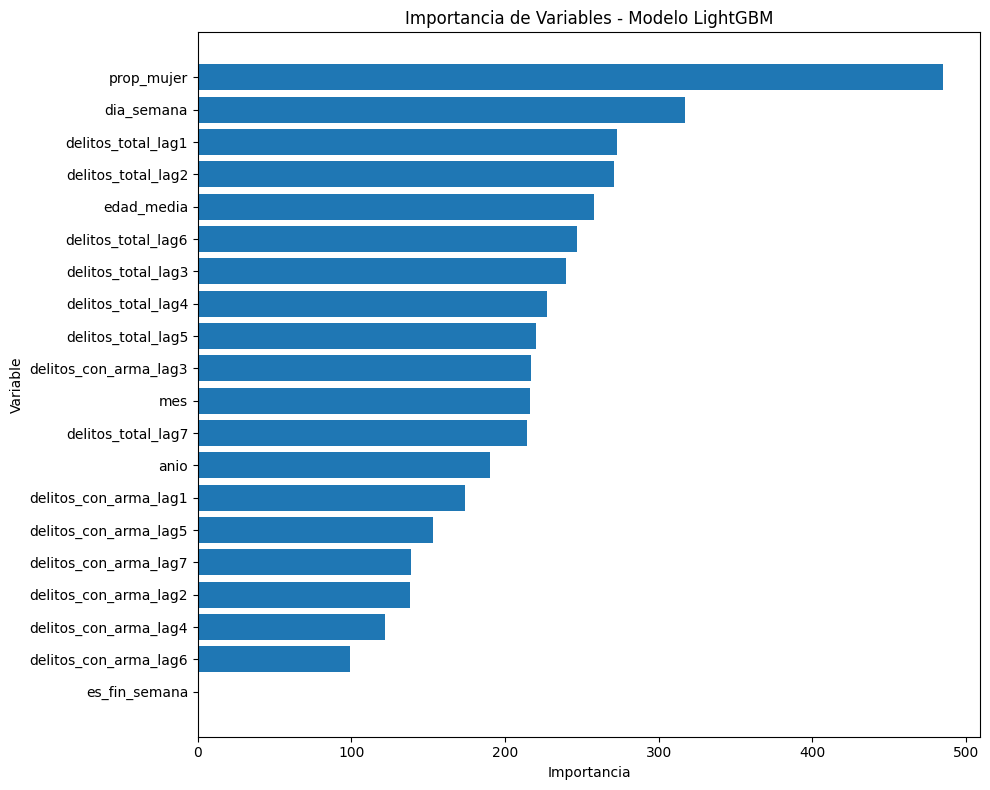

In [ ]:
#import matplotlib.pyplot as plt
#import pandas as pd

# ============================================
# 1. Extraer el modelo entrenado dentro del pipeline
# ============================================
modelo_entrenado = pipeline_final.named_steps["lgbm"]

# ============================================
# 2. Obtener importancias
# ============================================
importancias = modelo_entrenado.feature_importances_
variables = features

# DataFrame ordenado
df_import = pd.DataFrame({
    "variable": variables,
    "importancia": importancias
}).sort_values("importancia", ascending=True)

# ============================================
# 3. Gráfico de barras horizontal
# ============================================
plt.figure(figsize=(10, 8))
plt.barh(df_import["variable"], df_import["importancia"])
plt.title("Importancia de Variables - Modelo LightGBM")
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.tight_layout()

plt.show()


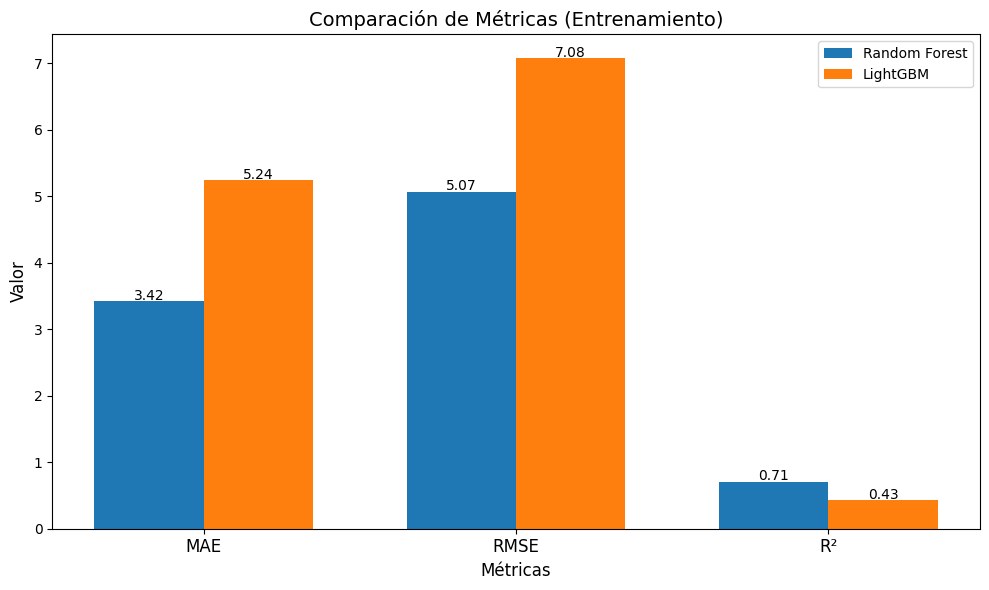

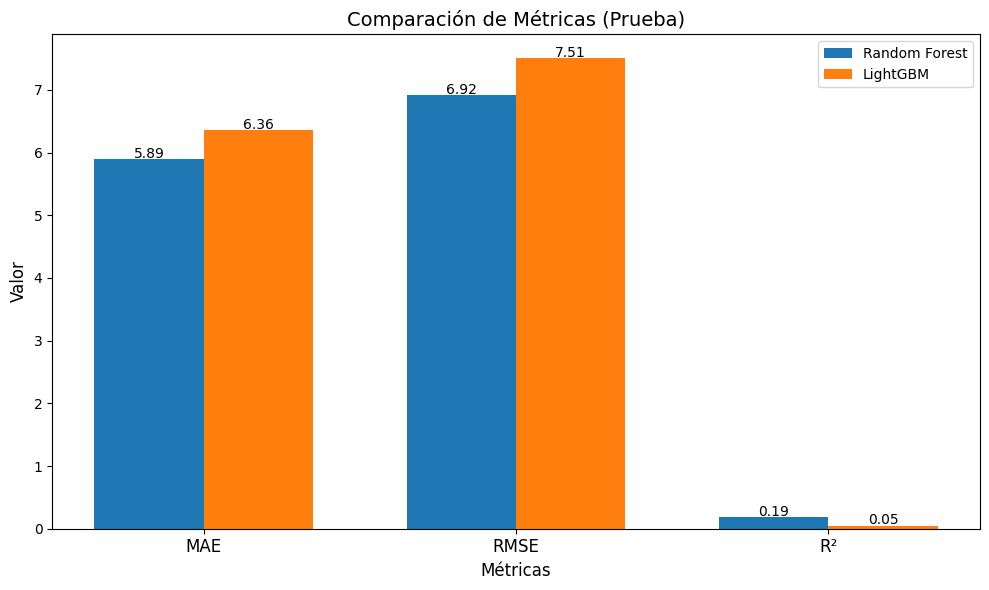

In [ ]:
# ============================================
# 1. Datos de los modelos
# ============================================

metricas = ["MAE", "RMSE", "R²"]

# Entrenamiento
rf_train =  [3.42, 5.07, 0.71]
lgbm_train = [5.24, 7.08, 0.43]

# Prueba
rf_test =  [5.89, 6.92, 0.19]
lgbm_test = [6.36, 7.51, 0.05]

x = np.arange(len(metricas))
width = 0.35

# ============================================
# 2. Gráfico: ENTRENAMIENTO
# ============================================
plt.figure(figsize=(10, 6))

plt.bar(x - width/2, rf_train, width, label="Random Forest", color="#1f77b4")
plt.bar(x + width/2, lgbm_train, width, label="LightGBM", color="#ff7f0e")

plt.xlabel("Métricas", fontsize=12)
plt.ylabel("Valor", fontsize=12)
plt.title("Comparación de Métricas (Entrenamiento)", fontsize=14)
plt.xticks(x, metricas, fontsize=12)
plt.legend()

# Etiquetas arriba de cada barra
for i, v in enumerate(rf_train):
    plt.text(x[i] - width/2, v + 0.02, f"{v:.2f}", ha='center')

for i, v in enumerate(lgbm_train):
    plt.text(x[i] + width/2, v + 0.02, f"{v:.2f}", ha='center')

plt.tight_layout()
plt.show()

# ============================================
# 3. Gráfico: PRUEBA
# ============================================
plt.figure(figsize=(10, 6))

plt.bar(x - width/2, rf_test, width, label="Random Forest", color="#1f77b4")
plt.bar(x + width/2, lgbm_test, width, label="LightGBM", color="#ff7f0e")

plt.xlabel("Métricas", fontsize=12)
plt.ylabel("Valor", fontsize=12)
plt.title("Comparación de Métricas (Prueba)", fontsize=14)
plt.xticks(x, metricas, fontsize=12)
plt.legend()

# Etiquetas arriba de cada barra
for i, v in enumerate(rf_test):
    plt.text(x[i] - width/2, v + 0.02, f"{v:.2f}", ha='center')

for i, v in enumerate(lgbm_test):
    plt.text(x[i] + width/2, v + 0.02, f"{v:.2f}", ha='center')

plt.tight_layout()
plt.show()
